# 05 - Baseline Model Improved

In this notebook, we are going to improve the logistic regression model.

(Also gonna work with a sample of our dataset to be able to evaluate faster the results.
Our sample is gonna be equalized/normalize by the classes, equal amount for each class)

We are gonna try:
   - different C values;
   - different solver;
   - different penality;
Evaluate the results with: Accuracy, Precision, Recall and f1


### Steps: 
 - Importing/accessing the data
 - Separeting the Train and Test Data
 - Fit the model (in this case, train the logistic regression)
 - Evaluate the model
    - Accuracy, Precision, Recall, f1  .....  Confusion Matrix 
 - Using the model to predict the specifics images

## Importing/accessing the data

First, importing the libs and treating the data:

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

dataset_directory = '../datasets/dataset_normal/'

# Load and preprocess images
def load_images(directory):
    images = []
    labels = []
    for label, folder in enumerate(os.listdir(directory)):
        for filename in os.listdir(os.path.join(directory, folder)):
            img = cv2.imread(os.path.join(directory, folder, filename))
            img = cv2.resize(img, (100, 100))  # Resize image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            images.append(img.flatten())  # Flatten image
            labels.append(label)
    return np.array(images), np.array(labels)

# Feature extraction
images, labels = load_images(dataset_directory)

# Feature scaling (optional but recommended)
images = images / 255.0  # Scale pixel values to range [0, 1]


In [2]:
# Sanity Check
images.shape
# labels

(17092, 10000)

## Separating the Train and Test Data

Spliting data into training and testing sets

In [3]:
# Spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, test_size=0.2, stratify=labels, random_state=42)


In [4]:
print(X_train.shape)
print(y_train.shape)
# print(y_train)
print(X_test.shape)
print(y_train.shape)

(13673, 10000)
(13673,)
(3419, 10000)
(13673,)


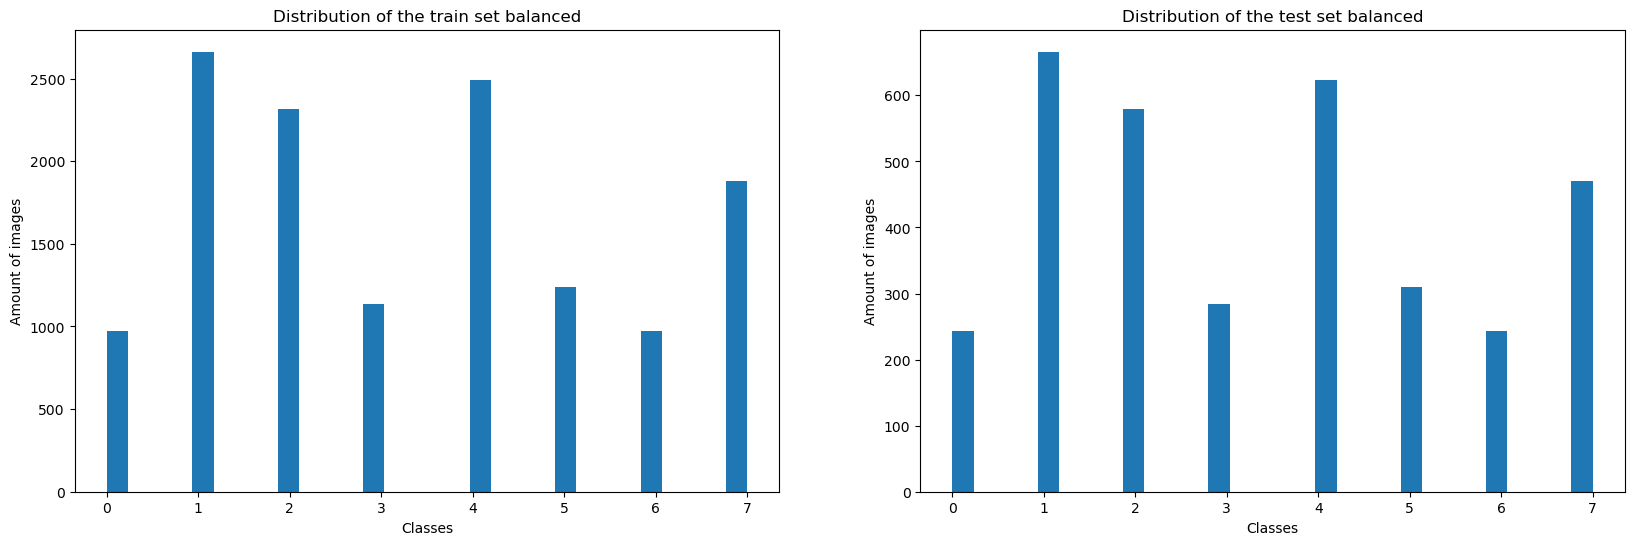

In [5]:
import matplotlib.pyplot as plt

# Plotting the y_ values to see how is the distribution
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30)
plt.title('Distribution of the train set balanced')
plt.xlabel('Classes')
plt.ylabel('Amount of images')

plt.subplot(1, 2, 2)
plt.hist(y_test, bins=30)
plt.title('Distribution of the test set balanced')
plt.xlabel('Classes')
plt.ylabel('Amount of images')

plt.show()


In [6]:
from sklearn.utils import resample

# Calculate the size of the smallest class
min_class_size = min(np.bincount(y_train))

# Undersampling majority classes to match the size of the minority class
X_train_balanced = []
y_train_balanced = []
for i in range(8):  # Assuming we have 8 classes
    X_class_i = X_train[y_train == i]
    y_class_i = y_train[y_train == i]
    X_class_i_resampled, y_class_i_resampled = resample(X_class_i, y_class_i, n_samples=min_class_size, random_state=42)
    X_train_balanced.append(X_class_i_resampled)
    y_train_balanced.append(y_class_i_resampled)

X_train_balanced = np.concatenate(X_train_balanced)
y_train_balanced = np.concatenate(y_train_balanced)

#---
# Doing the same for the test set

# Calculate the size of the smallest class
min_class_size_test = min(np.bincount(y_test))

X_test_balanced = []
y_test_balanced = []
for i in range(8):  # Assuming we have 8 classes
    X_class_i = X_test[y_test == i]
    y_class_i = y_test[y_test == i]
    X_class_i_resampled, y_class_i_resampled = resample(X_class_i, y_class_i, n_samples=min_class_size_test, random_state=42)
    X_test_balanced.append(X_class_i_resampled)
    y_test_balanced.append(y_class_i_resampled)

X_test_balanced = np.concatenate(X_test_balanced)
y_test_balanced = np.concatenate(y_test_balanced)

# #-------------------------
# #-------------------------
# # Oversampling minority classes to match the size of the majority class
# # You can use techniques like SMOTE for better synthetic sampling
# # Here, I'm just duplicating existing samples
# X_train_balanced_oversampled = []
# y_train_balanced_oversampled = []
# for i in range(8):  # Assuming you have 8 classes
#     X_class_i = X_train[y_train == i]
#     y_class_i = y_train[y_train == i]
#     X_class_i_oversampled, y_class_i_oversampled = resample(X_class_i, y_class_i, n_samples=len(X_train_balanced), random_state=42)
#     X_train_balanced_oversampled.append(X_class_i_oversampled)
#     y_train_balanced_oversampled.append(y_class_i_oversampled)

# X_train_balanced_oversampled = np.concatenate(X_train_balanced_oversampled)
# y_train_balanced_oversampled = np.concatenate(y_train_balanced_oversampled)


In [7]:
# Seeing how is the shape of the data
print(X_train_balanced.shape)
print(y_train_balanced.shape)
# print(y_train)
print(X_test_balanced.shape)
print(y_test_balanced.shape)

(7768, 10000)
(7768,)
(1944, 10000)
(1944,)


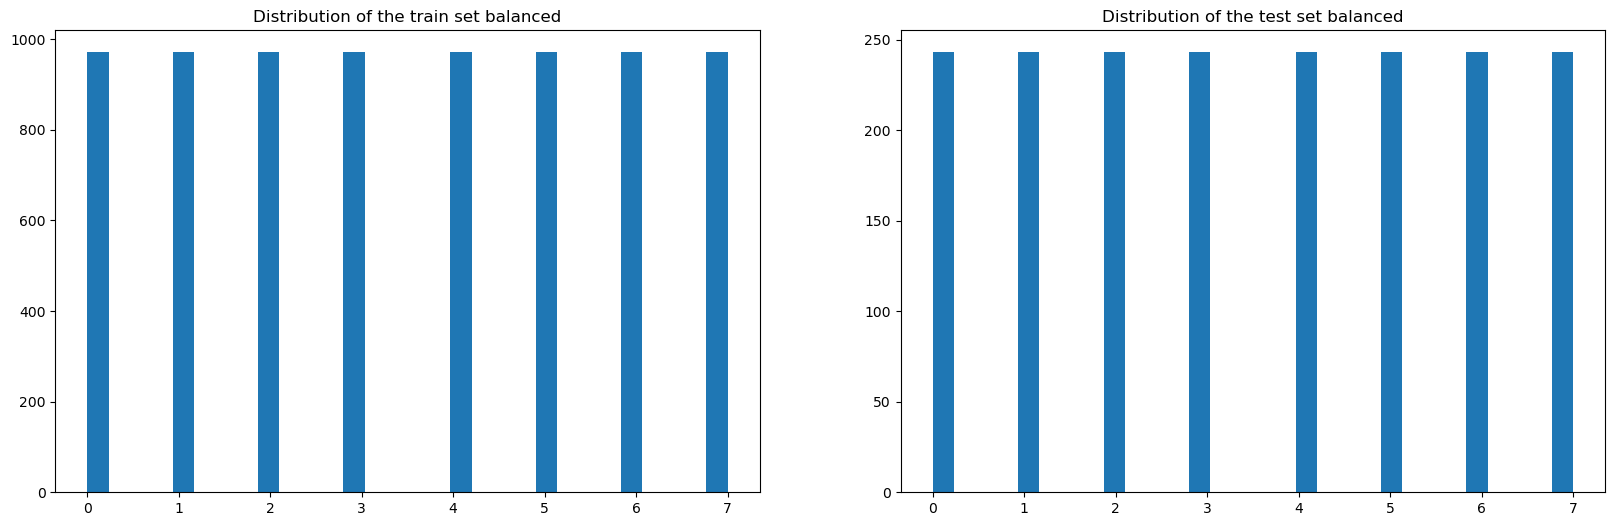

In [8]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.hist(y_train_balanced, bins=30)
plt.title('Distribution of the train set balanced')
# plt.show()

plt.subplot(1, 2, 2)
plt.hist(y_test_balanced, bins=30)
plt.title('Distribution of the test set balanced')

plt.show()


## Training the model (train the logistic regression)

Training/fiting the models

### Optimizing for C in Logistic Regression


In [26]:
# Range of C values
c_values = [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000]

# Setting empty lists
train_accuracies = []
validation_accuracies = []

# Iterate over the C values
for value in c_values:

    # Instantiate a log reg and fit to the train set
    logreg = LogisticRegression(
        C=value,
        max_iter=10000,
        n_jobs=-1,
        random_state=1,
        verbose=1,
    ).fit(X_train_balanced, y_train_balanced)

    # Score on the train set and append this accuracy to its respective list
    train_accuracies.append(logreg.score(X_train_balanced, y_train_balanced))

    # Score on the validation set and append this accuracy to its respective list
    validation_accuracies.append(logreg.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        80008     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21107D+04    |proj g|=  3.13919D+02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
80008     46     52      1     0     0   1.177D-01   1.165D+04
  F =   11654.869065688841     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        80008     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21107D+04    |proj g|=  3.13919D+02


 This problem is unconstrained.



At iterate   50    f=  9.95093D+03    |proj g|=  1.53839D+01

At iterate  100    f=  9.83503D+03    |proj g|=  3.47974D+01

At iterate  150    f=  9.80670D+03    |proj g|=  9.75710D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
80008    184    197      1     0     0   7.057D-01   9.807D+03
  F =   9806.6902855007847     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        80008     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21107D+04    |proj g|=  3.13919D+02


 This problem is unconstrained.



At iterate   50    f=  7.15324D+03    |proj g|=  1.16862D+01

At iterate  100    f=  7.14178D+03    |proj g|=  9.76791D+00

At iterate  150    f=  7.14110D+03    |proj g|=  8.01624D+00

At iterate  200    f=  7.13715D+03    |proj g|=  7.26183D+00

At iterate  250    f=  7.07153D+03    |proj g|=  3.26515D+01

At iterate  300    f=  7.01153D+03    |proj g|=  4.03045D+00

At iterate  350    f=  7.00586D+03    |proj g|=  5.42802D+00

At iterate  400    f=  7.00538D+03    |proj g|=  2.32931D+00

At iterate  450    f=  7.00533D+03    |proj g|=  1.59309D+00

At iterate  500    f=  7.00528D+03    |proj g|=  2.62277D+00

At iterate  550    f=  7.00380D+03    |proj g|=  8.61134D+00

At iterate  600    f=  6.99979D+03    |proj g|=  1.73332D+00

At iterate  650    f=  6.99942D+03    |proj g|=  1.46249D+00

At iterate  700    f=  6.99935D+03    |proj g|=  1.56135D+00

At iterate  750    f=  6.99868D+03    |proj g|=  2.54692D+00

At iterate  800    f=  6.99481D+03    |proj g|=  4.65620D+00

At iter

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        80008     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21107D+04    |proj g|=  3.13919D+02


 This problem is unconstrained.



At iterate   50    f=  5.09032D+03    |proj g|=  3.11913D+01

At iterate  100    f=  4.79050D+03    |proj g|=  5.55601D+01

At iterate  150    f=  4.69469D+03    |proj g|=  2.92733D+01

At iterate  200    f=  4.66758D+03    |proj g|=  8.12553D+00

At iterate  250    f=  4.65921D+03    |proj g|=  5.75493D+00

At iterate  300    f=  4.65673D+03    |proj g|=  5.01413D+00

At iterate  350    f=  4.65599D+03    |proj g|=  4.83576D+00

At iterate  400    f=  4.65559D+03    |proj g|=  4.42778D+00

At iterate  450    f=  4.65514D+03    |proj g|=  5.49471D+00

At iterate  500    f=  4.65306D+03    |proj g|=  5.60407D+00

At iterate  550    f=  4.64951D+03    |proj g|=  4.14201D+00

At iterate  600    f=  4.63364D+03    |proj g|=  1.96370D+01

At iterate  650    f=  4.59956D+03    |proj g|=  4.66883D+00

At iterate  700    f=  4.57423D+03    |proj g|=  9.39607D+00

At iterate  750    f=  4.55971D+03    |proj g|=  4.33475D+00

At iterate  800    f=  4.55636D+03    |proj g|=  6.47406D+00

At iter

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  5.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        80008     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21107D+04    |proj g|=  3.13919D+02


 This problem is unconstrained.



At iterate   50    f=  4.44114D+03    |proj g|=  3.80033D+01

At iterate  100    f=  3.69815D+03    |proj g|=  2.47965D+01

At iterate  150    f=  3.28248D+03    |proj g|=  1.75718D+01

At iterate  200    f=  2.87043D+03    |proj g|=  1.32619D+01

At iterate  250    f=  2.71543D+03    |proj g|=  1.91738D+01

At iterate  300    f=  2.59976D+03    |proj g|=  1.36118D+01

At iterate  350    f=  2.49794D+03    |proj g|=  7.77829D+00

At iterate  400    f=  2.46302D+03    |proj g|=  6.82341D+00

At iterate  450    f=  2.43434D+03    |proj g|=  1.32500D+01

At iterate  500    f=  2.42418D+03    |proj g|=  4.18740D+00

At iterate  550    f=  2.41871D+03    |proj g|=  3.61685D+00

At iterate  600    f=  2.41371D+03    |proj g|=  5.46129D+00

At iterate  650    f=  2.40962D+03    |proj g|=  3.04838D+00

At iterate  700    f=  2.40880D+03    |proj g|=  2.90634D+00

At iterate  750    f=  2.40788D+03    |proj g|=  4.63571D+00

At iterate  800    f=  2.40682D+03    |proj g|=  2.62192D+00

At iter

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  7.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        80008     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21107D+04    |proj g|=  3.13919D+02


 This problem is unconstrained.



At iterate   50    f=  4.34393D+03    |proj g|=  3.68220D+01

At iterate  100    f=  3.41054D+03    |proj g|=  2.41499D+01

At iterate  150    f=  2.79811D+03    |proj g|=  1.34069D+01

At iterate  200    f=  2.18582D+03    |proj g|=  1.63599D+01

At iterate  250    f=  1.72427D+03    |proj g|=  1.42494D+01

At iterate  300    f=  1.44041D+03    |proj g|=  1.46809D+01

At iterate  350    f=  1.27900D+03    |proj g|=  1.10873D+01

At iterate  400    f=  1.09164D+03    |proj g|=  6.44259D+00

At iterate  450    f=  9.84057D+02    |proj g|=  7.55427D+00

At iterate  500    f=  9.24134D+02    |proj g|=  3.28852D+00

At iterate  550    f=  8.68970D+02    |proj g|=  3.99652D+00

At iterate  600    f=  8.39627D+02    |proj g|=  2.96993D+00

At iterate  650    f=  8.22925D+02    |proj g|=  3.85929D+00

At iterate  700    f=  8.09834D+02    |proj g|=  1.76145D+00

At iterate  750    f=  7.94719D+02    |proj g|=  3.39400D+00

At iterate  800    f=  7.83452D+02    |proj g|=  1.13053D+00

At iter

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 12.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        80008     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21107D+04    |proj g|=  3.13919D+02


 This problem is unconstrained.



At iterate   50    f=  4.21149D+03    |proj g|=  4.59831D+01

At iterate  100    f=  3.46406D+03    |proj g|=  3.59972D+01

At iterate  150    f=  3.07247D+03    |proj g|=  2.51250D+01

At iterate  200    f=  2.64924D+03    |proj g|=  2.16286D+01

At iterate  250    f=  1.65407D+03    |proj g|=  2.05674D+01

At iterate  300    f=  1.28578D+03    |proj g|=  3.01601D+01

At iterate  350    f=  7.60218D+02    |proj g|=  2.25076D+01

At iterate  400    f=  4.39807D+02    |proj g|=  1.01283D+01

At iterate  450    f=  3.30873D+02    |proj g|=  3.42406D+00

At iterate  500    f=  2.81479D+02    |proj g|=  1.42713D+00

At iterate  550    f=  2.52541D+02    |proj g|=  5.41989D+00

At iterate  600    f=  2.35083D+02    |proj g|=  2.62327D+00

At iterate  650    f=  2.14432D+02    |proj g|=  4.50376D+00

At iterate  700    f=  2.02466D+02    |proj g|=  1.00461D+00

At iterate  750    f=  1.95973D+02    |proj g|=  6.66404D-01

At iterate  800    f=  1.90183D+02    |proj g|=  1.62257D+00

At iter

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 15.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        80008     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21107D+04    |proj g|=  3.13919D+02


 This problem is unconstrained.



At iterate   50    f=  4.35507D+03    |proj g|=  3.34169D+01

At iterate  100    f=  3.77478D+03    |proj g|=  4.86927D+01

At iterate  150    f=  2.73188D+03    |proj g|=  2.28599D+01

At iterate  200    f=  2.26705D+03    |proj g|=  2.22541D+01

At iterate  250    f=  1.52886D+03    |proj g|=  1.39510D+01

At iterate  300    f=  1.07668D+03    |proj g|=  1.47298D+01

At iterate  350    f=  7.05783D+02    |proj g|=  1.93403D+01

At iterate  400    f=  4.38312D+02    |proj g|=  8.10203D+00

At iterate  450    f=  2.59856D+02    |proj g|=  6.38129D+00

At iterate  500    f=  1.58198D+02    |proj g|=  5.96724D+00

At iterate  550    f=  8.69390D+01    |proj g|=  1.36643D+00

At iterate  600    f=  5.74424D+01    |proj g|=  1.39084D+00

At iterate  650    f=  4.41605D+01    |proj g|=  8.39697D-01

At iterate  700    f=  3.98163D+01    |proj g|=  3.43561D-01

At iterate  750    f=  3.72986D+01    |proj g|=  2.68463D-01

At iterate  800    f=  3.55134D+01    |proj g|=  9.53028D-02

At iter

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 15.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        80008     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21107D+04    |proj g|=  3.13919D+02


 This problem is unconstrained.



At iterate   50    f=  4.35524D+03    |proj g|=  3.34750D+01

At iterate  100    f=  3.42678D+03    |proj g|=  3.37156D+01

At iterate  150    f=  2.63595D+03    |proj g|=  2.54874D+01

At iterate  200    f=  2.07792D+03    |proj g|=  1.57190D+01

At iterate  250    f=  1.29527D+03    |proj g|=  1.19040D+01

At iterate  300    f=  8.52118D+02    |proj g|=  2.85862D+01

At iterate  350    f=  4.20050D+02    |proj g|=  3.00150D+01

At iterate  400    f=  1.65881D+02    |proj g|=  3.32097D+00

At iterate  450    f=  2.95600D+01    |proj g|=  1.23484D+00

At iterate  500    f=  1.86527D+01    |proj g|=  1.27998D-01

At iterate  550    f=  1.52969D+01    |proj g|=  8.48211D-02

At iterate  600    f=  1.38152D+01    |proj g|=  6.15716D-02

At iterate  650    f=  1.23227D+01    |proj g|=  4.53396D-02

At iterate  700    f=  1.16050D+01    |proj g|=  3.21038D-02

At iterate  750    f=  1.06024D+01    |proj g|=  3.57203D-02

At iterate  800    f=  9.97969D+00    |proj g|=  3.34849D-02

At iter

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 68.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        80008     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21107D+04    |proj g|=  3.13919D+02


 This problem is unconstrained.



At iterate   50    f=  4.35525D+03    |proj g|=  3.34797D+01

At iterate  100    f=  3.54221D+03    |proj g|=  2.88328D+01

At iterate  150    f=  2.90225D+03    |proj g|=  3.20778D+01

At iterate  200    f=  1.99272D+03    |proj g|=  1.53729D+01

At iterate  250    f=  1.44691D+03    |proj g|=  2.09291D+01

At iterate  300    f=  9.34403D+02    |proj g|=  1.10306D+01

At iterate  350    f=  5.33525D+02    |proj g|=  6.81909D+00

At iterate  400    f=  3.73915D+02    |proj g|=  6.12790D+00

At iterate  450    f=  1.76064D+02    |proj g|=  4.89070D+00

At iterate  500    f=  8.03103D+01    |proj g|=  1.78397D+00

At iterate  550    f=  5.25554D+01    |proj g|=  2.55529D+00

At iterate  600    f=  3.89315D+01    |proj g|=  7.30686D-01

At iterate  650    f=  2.70211D+01    |proj g|=  7.33395D-01

At iterate  700    f=  1.91391D+01    |proj g|=  3.74354D-01

At iterate  750    f=  1.39810D+01    |proj g|=  4.39905D-01

At iterate  800    f=  8.69636D+00    |proj g|=  2.14710D-01

At iter

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 15.8min finished


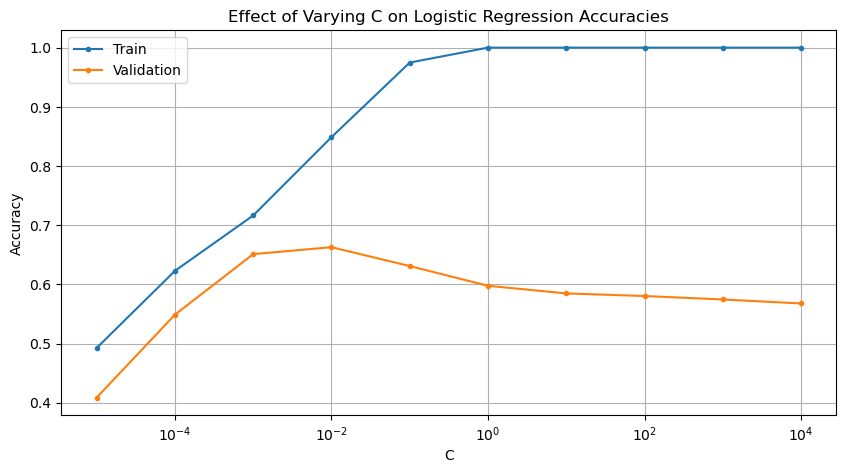

In [27]:
import pandas as pd

# Create a dataframe
scores_df=pd.DataFrame({'C value': c_values, 'train accuracy': train_accuracies, 'validation accuracy': validation_accuracies})

# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(c_values, train_accuracies, label='Train', marker='.')
plt.plot(c_values, validation_accuracies, label='Validation', marker='.')
plt.legend()
plt.title('Effect of Varying C on Logistic Regression Accuracies')
plt.xscale('log') # Put the x-axis on a log scale; this is important because the C values vary in orders of magnitude
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [28]:
best_c=c_values[np.argmax(validation_accuracies)]
best_c

0.01

In [31]:
# Instantiate a log reg and fit to the remainder set
validated_logreg = LogisticRegression(
    C=best_c,
    max_iter=20000,
    # verbose=1,
    random_state=1
    ).fit(X_train_balanced, y_train_balanced)

# Print the test accuracy
print(f'Accuracy on test set: {validated_logreg.score(X_test, y_test)}')

Accuracy on test set: 0.6653992395437263


### Optimizing for C in Logistic Regression with Cross validation

In [33]:
from sklearn.model_selection import cross_val_score

# Range of C values that was used before
c_values = [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000]

cv_accuracies = []

for value in c_values:

    # Instantiate a log reg
    logreg = LogisticRegression(
        C=value, 
        random_state=1, 
        n_jobs=-1,
        max_iter=10000)

    # Pass the model and the remainder set into the cross-validation function, then get cross-validated accuracy by taking the mean
    cv_accuracy = np.mean(cross_val_score(logreg, X_train_balanced, y_train_balanced, cv=5, n_jobs=-1))

    # Append the cross-validated accuracy to the list set up above
    cv_accuracies.append(cv_accuracy)

    # Print something at the end of each iteration
    print(f'For a C value of {value}, the cross-validated accuracy is {round(cv_accuracy, 6)}')

For a C value of 1e-05, the cross-validated accuracy is 0.478538
For a C value of 0.0001, the cross-validated accuracy is 0.599934
For a C value of 0.001, the cross-validated accuracy is 0.667585
For a C value of 0.01, the cross-validated accuracy is 0.733862
For a C value of 0.1, the cross-validated accuracy is 0.777303
For a C value of 1, the cross-validated accuracy is 0.770434
For a C value of 10, the cross-validated accuracy is 0.764595
For a C value of 100, the cross-validated accuracy is 0.762534
For a C value of 1000, the cross-validated accuracy is 0.760988
For a C value of 10000, the cross-validated accuracy is 0.752575


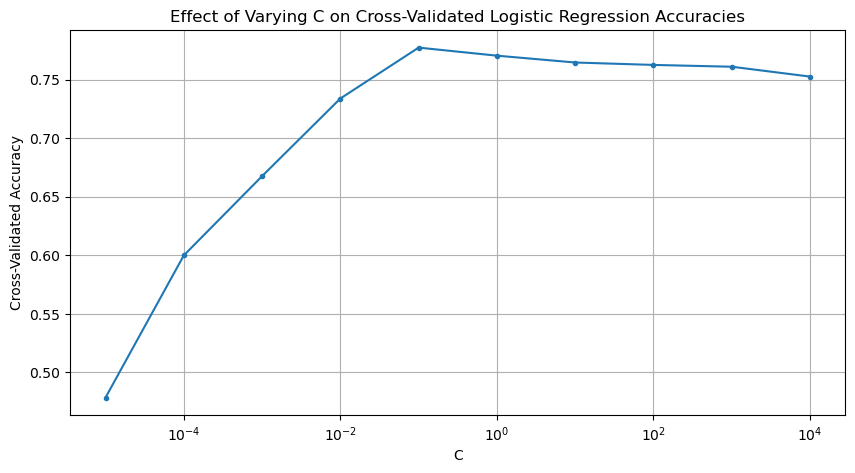

In [34]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(c_values, cv_accuracies, marker = '.')
plt.title('Effect of Varying C on Cross-Validated Logistic Regression Accuracies')
plt.xscale('log') # Put the x-axis on a log scale; this is important because the C values vary in orders of magnitude
plt.xlabel('C')
plt.ylabel('Cross-Validated Accuracy')
plt.grid()
plt.show()

The optimal C value (using the cross-fold) is: 

In [11]:
# BEST PARAMETER

# Instantiate a log reg and fit to the remainder set
cross_validated_logreg = LogisticRegression(
    C=0.1, 
    max_iter=10000,
    n_jobs=-1,
    random_state=1,
    # verbose=1
    ).fit(X_train_balanced, y_train_balanced)

# Print the accuracies
print(f'Accuracy on remainder set: {cross_validated_logreg.score(X_train_balanced, y_train_balanced)}')
print(f'Accuracy on test set: {cross_validated_logreg.score(X_test, y_test)}')

Accuracy on remainder set: 0.9747596153846154
Accuracy on test set: 0.6308862240421176


In [10]:
# #To save the model after training

# import joblib

# # Save the model
# joblib.dump(cross_validated_logreg, 'logistic_regression_model_sampled_bestC01_lbfgs_l2.pkl')

In [46]:
# Evaluating the model
y_pred = cross_validated_logreg.predict(X_test)
y_pred_train = cross_validated_logreg.predict(X_train_balanced)

accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train_balanced, y_pred_train)
print("Accuracy test:", accuracy_test)
print("Accuracy train:", accuracy_train)

Accuracy test: 0.6308862240421176
Accuracy train: 0.9747596153846154


In [25]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.45      0.62      0.52       243
           1       0.76      0.61      0.68       666
           2       0.51      0.36      0.42       579
           3       0.39      0.54      0.46       284
           4       0.63      0.62      0.62       624
           5       0.58      0.68      0.63       310
           6       0.62      0.76      0.68       243
           7       0.97      0.97      0.97       470

    accuracy                           0.63      3419
   macro avg       0.61      0.65      0.62      3419
weighted avg       0.64      0.63      0.63      3419



### Confusion Matrix 

Plotting the confusion Matrix (as a porcentage) and observate the classification from the model

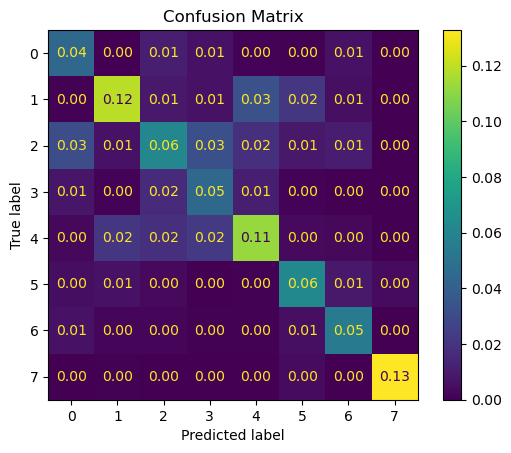

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='all', values_format='.2f')
plt.title('Confusion Matrix')
plt.show()


### One-vs-Rest (OvR) multiclass ROC

Evaluating the ROC-AUC from the models.

Using the LabelBinarizer to normalize the data, calculationg the micro and macro average and plotting all classes to see theirs respective curves/values.


More information at: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [27]:
from sklearn.preprocessing import LabelBinarizer

# use a LabelBinarizer to binarize the target by one-hot-encoding in a OvR fashion.
# This means that the target of shape (n_samples,) is mapped to a target of shape (n_samples, n_classes).

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

# #check the encoding of a specific class: #SanityCheck
# label_binarizer.transform([1])

(3419, 8)

In [28]:
cells = {
    0 : 'basophil',
    1 : 'eosinophil',
    2 : 'erythroblast',
    3 : 'ig',
    4 : 'lymphocyte',
    5 : 'monocyte',
    6 : 'neutrophil',
    7 : 'platelet',
}

In [30]:
logreg=cross_validated_logreg

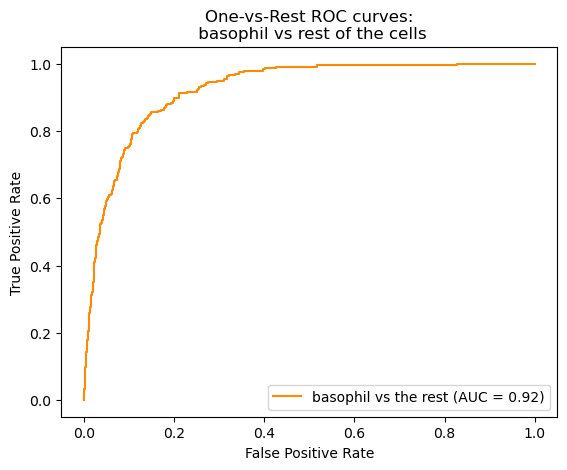

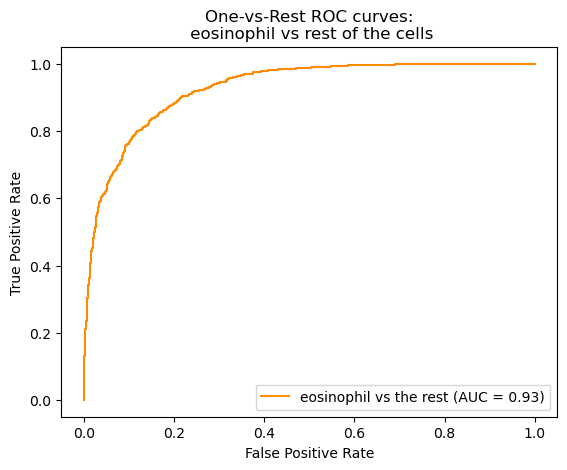

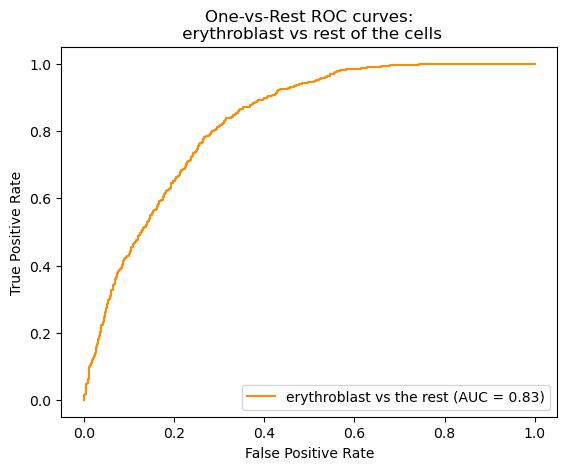

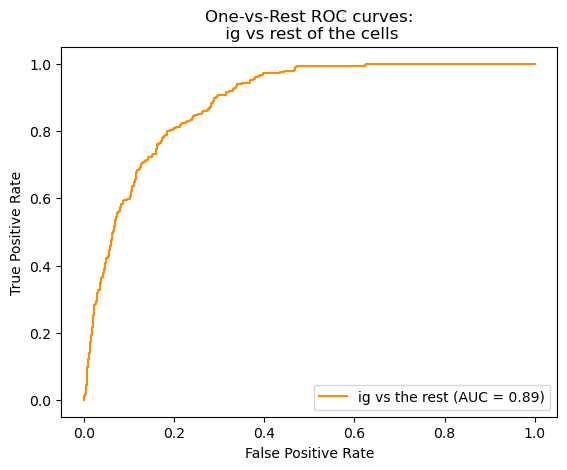

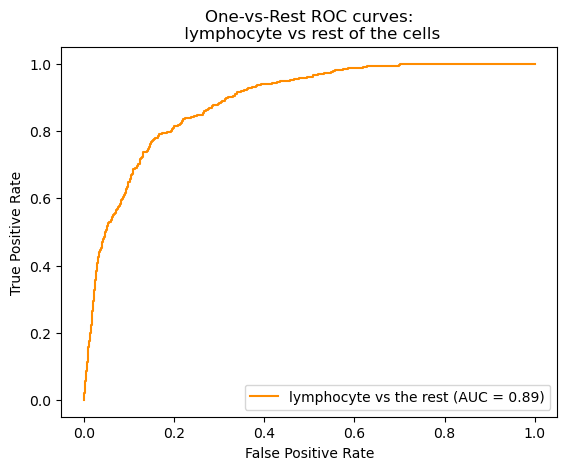

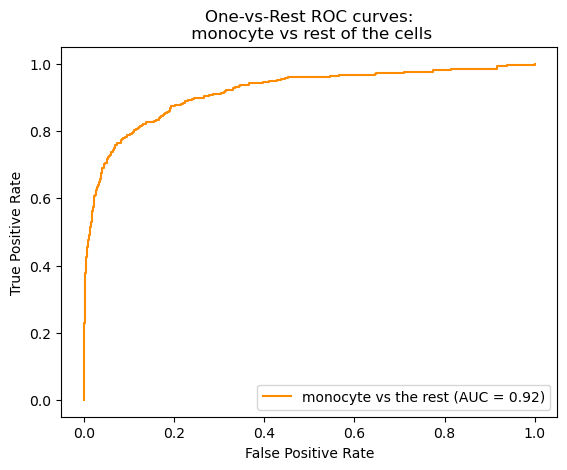

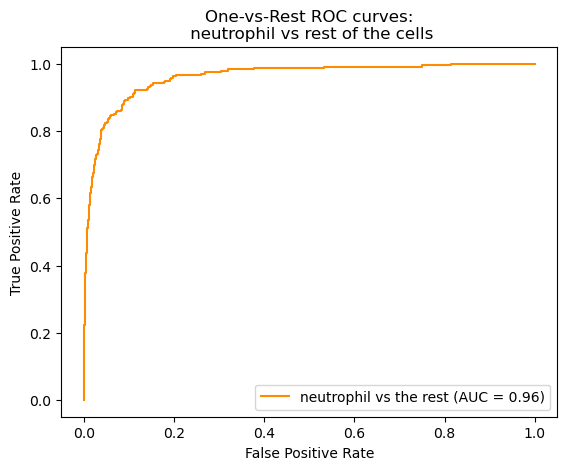

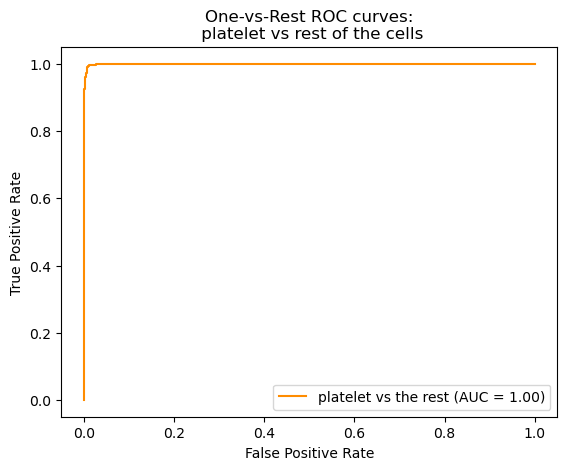

In [31]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

y_score = logreg.predict_proba(X_test)
# y_score= (logreg.predict_proba(X_test)[:, class_id] >= 0.9).astype(int) 
# print(y_pred_new_threshold)

for i in range(0,8):
    display = RocCurveDisplay.from_predictions(
        y_onehot_test[:, i],
        y_score[:, i],
        name=f"{cells[i]} vs the rest",
        color="darkorange",
    )
    _ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title='One-vs-Rest ROC curves:\n {} vs rest of the cells'.format(cells[i]),
)


In [32]:
from sklearn.metrics import auc, roc_curve, roc_auc_score

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

# ---------------------
# Can also evaluate with the build-in method, but for the next plot we need to have the variables

# micro_roc_auc_ovr = roc_auc_score(
#     y_test,
#     y_score,
#     multi_class="ovr",
#     average="micro",
# )

# print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")


Micro-averaged One-vs-Rest ROC AUC score:
0.93


In [33]:
# ROC curve using the OvR macro-average

n_classes = 8
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

# ---------------------
# Can also evaluate with the build-in method, but for the next plot we need to have the variables
# macro_roc_auc_ovr = roc_auc_score(
#     y_test,
#     y_score,
#     multi_class="ovr",
#     average="macro",
# )
# print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")


Macro-averaged One-vs-Rest ROC AUC score:
0.92


NOTE : In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferable over macro-averaging. In such cases, one can alternatively use a weighted macro-averaging, not demoed here.

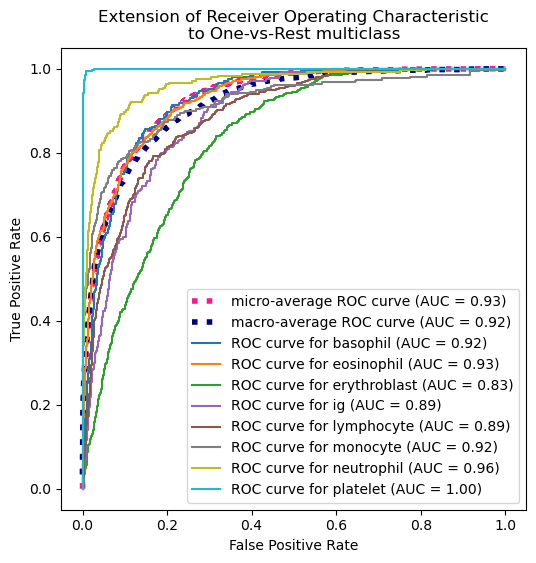

In [34]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

#Plotting micro-avg Roc curve
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

# Plotting Macro-AVG Roc curve
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

# Classes numbers
n_classes = 8

# Generate a color palette
colors = cycle(plt.cm.tab10(np.linspace(0, 1, n_classes)))

for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {cells[class_id]}",
        color=color,
        ax=ax,
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

#reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

## Using the model to predict the specifics images

In [35]:
# Load the model 

# logreg = joblib.load('../models/logistic_regression_model.pkl')
# result = logreg.score(X_test, y_test)
# print(result)

In [36]:
filename = '../datasets/dataset_normal/basophil/BA_47.jpg'
# filename = '../datasets/dataset_normal/neutrophil/BNE_715.jpg'

cells = {
    0 : 'basophil',
    1 : 'eosinophil',
    2 : 'erythroblast',
    3 : 'ig',
    4 : 'lymphocyte',
    5 : 'monocyte',
    6 : 'neutrophil',
    7 : 'platelet',
}

img = cv2.imread(os.path.join(filename))
img = cv2.resize(img, (100, 100))  # Resize image
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
X = img.flatten()  # Flatten image
X = X / 255.0  

result = logreg.predict([X])
print(f"The cell that was detect was: {cells[result[0]]}")

The cell that was detect was: basophil
